Plotting GA training statistics...
Saved fitness plot to ga_trained_models/ga_fitness_plot.png
Saved mutation params plot to ga_trained_models/ga_mutation_params_plot.png
Saved weights plot to ga_trained_models/ga_weights_plot.png
Plotting finished. Check the 'ga_trained_models' directory for PNG files.
If plots are not shown, uncomment 'plt.show()' lines in the script.


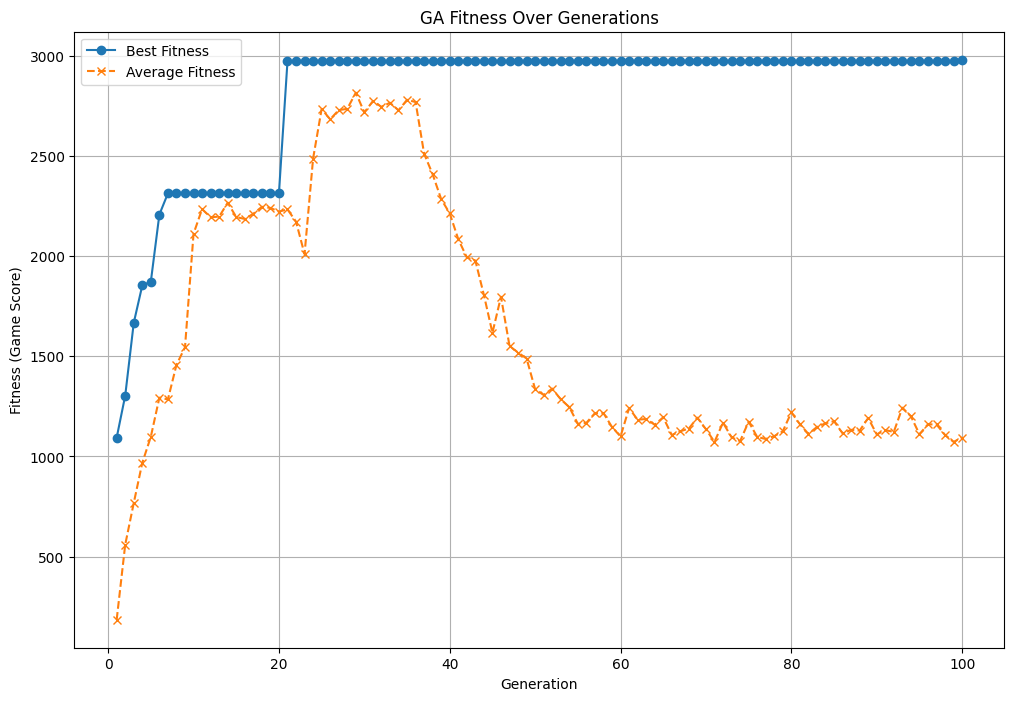

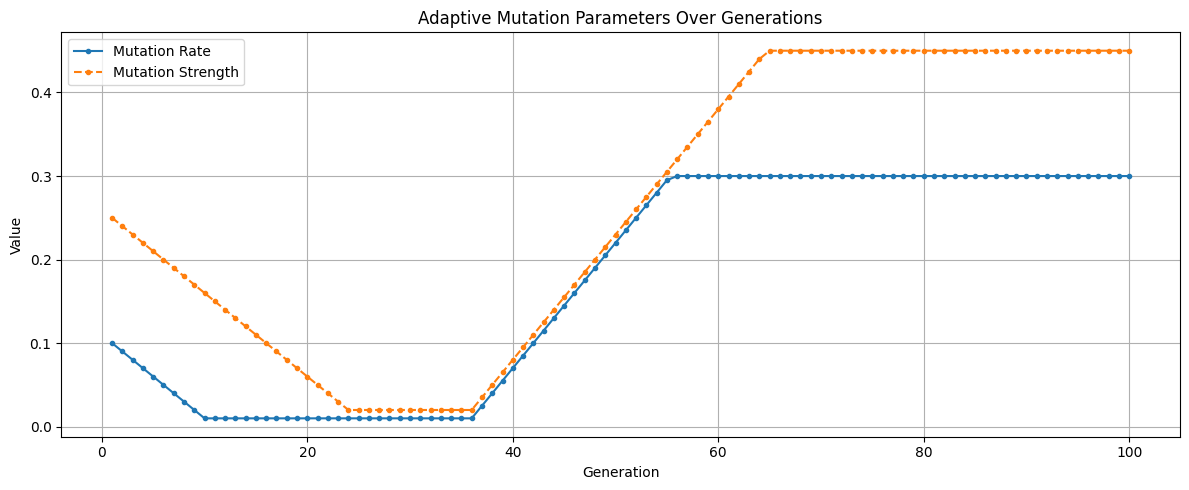

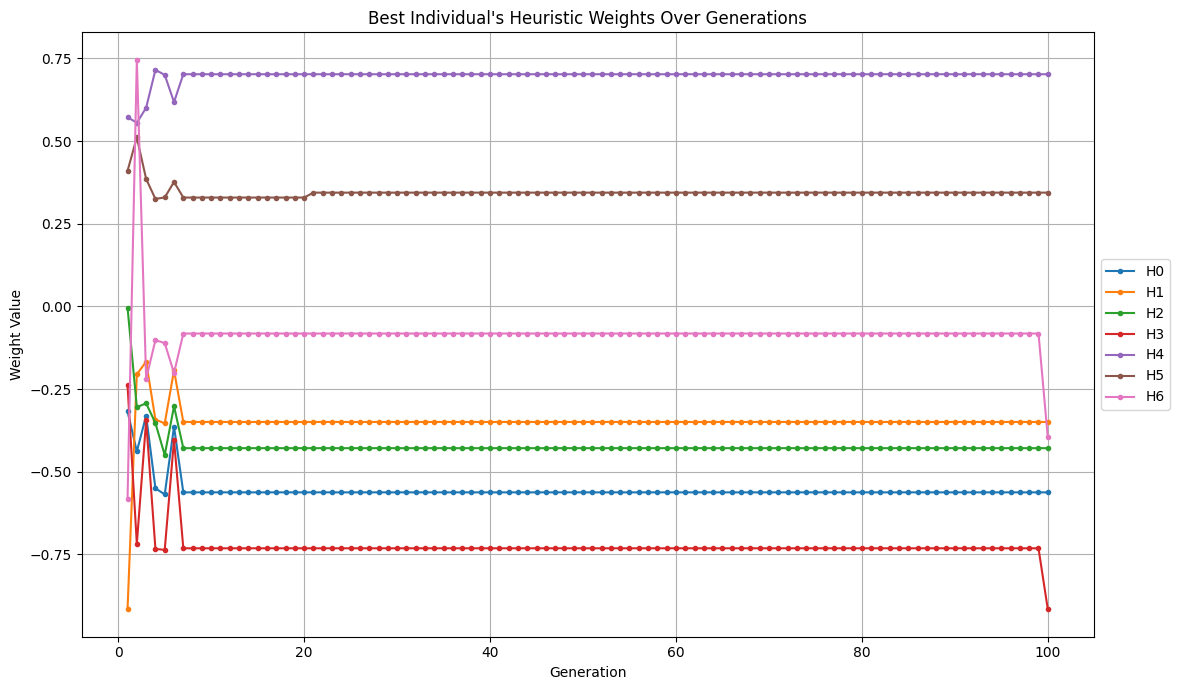

In [1]:
# plot_ga_stats.py
import pandas as pd
import matplotlib.pyplot as plt
import os
import settings as s_ai # To get log file path and heuristic count

def plot_ga_statistics(log_filepath=None):
    """
    Reads the GA training log CSV file and plots relevant statistics.
    """
    if log_filepath is None:
        log_filepath = os.path.join(s_ai.GA_MODEL_SAVE_DIR, s_ai.GA_LOG_FILE)

    if not os.path.exists(log_filepath):
        print(f"Error: Log file not found at {log_filepath}")
        return

    try:
        df = pd.read_csv(log_filepath)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    if df.empty:
        print("Log file is empty. No data to plot.")
        return

    generations = df['generation']

    # Plotting Fitness Trends
    plt.figure(figsize=(12, 8))
    
    plt.plot(generations, df['best_fitness'], label='Best Fitness', marker='o', linestyle='-')
    plt.plot(generations, df['average_fitness'], label='Average Fitness', marker='x', linestyle='--')
    plt.title('GA Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Game Score)')
    plt.legend()
    plt.grid(True)

    # plt.subplot(2, 1, 2)
    # plt.plot(generations, df['std_dev_fitness'], label='Std Dev of Fitness', marker='s', linestyle=':', color='green')
    # plt.title('Standard Deviation of Fitness Over Generations')
    # plt.xlabel('Generation')
    # plt.ylabel('Std Dev Fitness')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    plt.savefig(os.path.join(s_ai.GA_MODEL_SAVE_DIR, "ga_fitness_plot.png"))
    print(f"Saved fitness plot to {os.path.join(s_ai.GA_MODEL_SAVE_DIR, 'ga_fitness_plot.png')}")
    # plt.show() # Uncomment to display plots immediately

    # Plotting Mutation Rate and Strength
    if 'mutation_rate' in df.columns and 'mutation_strength' in df.columns:
        plt.figure(figsize=(12, 5))
        plt.plot(generations, df['mutation_rate'], label='Mutation Rate', marker='.', linestyle='-')
        plt.plot(generations, df['mutation_strength'], label='Mutation Strength', marker='.', linestyle='--')
        plt.title('Adaptive Mutation Parameters Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(s_ai.GA_MODEL_SAVE_DIR, "ga_mutation_params_plot.png"))
        print(f"Saved mutation params plot to {os.path.join(s_ai.GA_MODEL_SAVE_DIR, 'ga_mutation_params_plot.png')}")
        # plt.show() # Uncomment to display plots immediately
    else:
        print("Mutation rate/strength columns not found in log for plotting.")


    # Plotting Best Individual's Weights (Optional - can get crowded)
    # Heuristic names for legend (assuming order in s_ai matches log)
    heuristic_names = [f"H{i}" for i in range(s_ai.GA_NUM_HEURISTICS)] # Generic names
    # Or define them more descriptively if you have them:
    # heuristic_names = [
    #     "Agg. Height", "Num Holes", "Bumpiness", 
    #     "Block Placed R.", "Clear R.", "Almost Full R.", "Game Lost P."
    # ]


    num_heuristics_in_log = 0
    for col in df.columns:
        if col.startswith('best_weight_'):
            num_heuristics_in_log +=1
    
    if num_heuristics_in_log == s_ai.GA_NUM_HEURISTICS:
        plt.figure(figsize=(14, 7))
        for i in range(s_ai.GA_NUM_HEURISTICS):
            weight_col_name = f'best_weight_{i}'
            if weight_col_name in df.columns:
                 plt.plot(generations, df[weight_col_name], label=heuristic_names[i] if i < len(heuristic_names) else weight_col_name, marker='.')
            else:
                print(f"Warning: Weight column {weight_col_name} not found in log.")

        plt.title('Best Individual\'s Heuristic Weights Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Weight Value')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.savefig(os.path.join(s_ai.GA_MODEL_SAVE_DIR, "ga_weights_plot.png"))
        print(f"Saved weights plot to {os.path.join(s_ai.GA_MODEL_SAVE_DIR, 'ga_weights_plot.png')}")
        # plt.show() # Uncomment to display plots immediately
    else:
        print(f"Number of weight columns in log ({num_heuristics_in_log}) does not match GA_NUM_HEURISTICS ({s_ai.GA_NUM_HEURISTICS}). Skipping weights plot.")



print("Plotting GA training statistics...")
plot_ga_statistics("/home/aljazjustin/blockdoku_AI/blockdoku-AI/ga_trained_models/training_log_12-05-15-57.csv")
print("Plotting finished. Check the 'ga_trained_models' directory for PNG files.")
print("If plots are not shown, uncomment 'plt.show()' lines in the script.")
